In [1]:
from main import load_mnist
import torch
import torchvision

Text(0.5, 1.0, 'Custom weights')

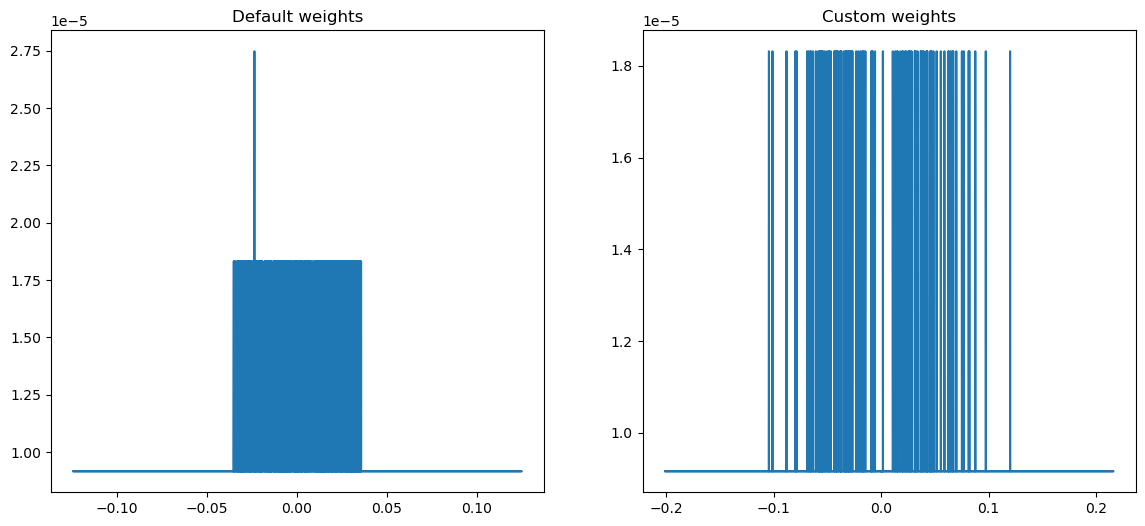

In [2]:
from deterministic.vanilla_net import VanillaCNN
from probabilistic.distribution_utils import to_discrete_distribution
import numpy as np
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available else 'cpu')
vanilla_net = VanillaCNN()
# Get all the initial weights and plot their distribution
default_weights = np.array([])
for param in vanilla_net.named_parameters():
    if 'weight' in param[0]:
        w = param[1].view(-1)
        default_weights = np.concatenate((default_weights, w.detach().numpy()), axis=None)

custom_weights = np.array([])
for param in vanilla_net.named_parameters():
    if 'weight' in param[0]:
        init_vals = torch.normal(mean=0.0, std=0.05, size=tuple(param[1].shape)).to(device)
        param[1].data = torch.nn.parameter.Parameter(init_vals)
        w = param[1].view(-1)
        custom_weights = np.concatenate((custom_weights, w.detach().numpy()), axis=None)

domain_values_default, range_values_default = to_discrete_distribution(default_weights)
domain_values_custom, range_values_custom = to_discrete_distribution(custom_weights)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(domain_values_default, range_values_default)
axs[0].set_title('Default weights')
axs[1].plot(domain_values_custom, range_values_custom)
axs[1].set_title('Custom weights')

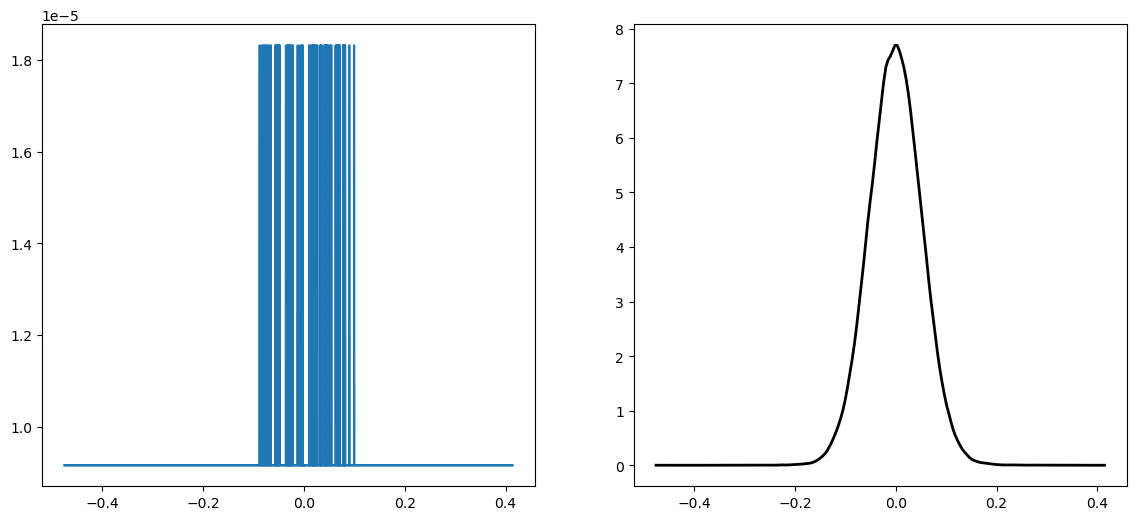

In [3]:
from scipy.stats import gaussian_kde

# Now in a similar way plot the weights distribution after training
trained_vanilla_net = VanillaCNN()
trained_vanilla_net.load_state_dict(torch.load('vanilla_network.pt'))
trained_vanilla_net.to(device)
trained_vanilla_net.eval()


optimized_weights = np.array([])
for param in trained_vanilla_net.named_parameters():
    if 'weight' in param[0]:
        w = param[1].view(-1)
        optimized_weights = np.concatenate((optimized_weights, w.detach().numpy()), axis=None)

# first fit a distribution to the data
density = gaussian_kde(optimized_weights)

domain_values_optimized, range_values_optimized = to_discrete_distribution(optimized_weights)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(domain_values_optimized, range_values_optimized)
cts_domain = np.linspace(np.min(domain_values_optimized), np.max(domain_values_optimized), 200)
axs[1].plot(cts_domain, density(cts_domain), 'k', linewidth=2)

In [6]:
import probabilistic.models as models
import probabilistic.hamiltonian as ham
import probabilistic.pipeline as pipeline
import importlib
importlib.reload(models)
importlib.reload(ham)
importlib.reload(pipeline)
from probabilistic.models import WeightModel
from probabilistic.hamiltonian import Hamiltonian
from probabilistic.pipeline import hmc

num_variational_params = 2
theta_prior_mean, theta_prior_cov = torch.zeros(num_variational_params), torch.eye(num_variational_params)
weight_probabilistic_model = WeightModel(prior_mean=theta_prior_mean, prior_variance=theta_prior_cov)
theta_prior = weight_probabilistic_model.gaussian_prior
theta_ll = weight_probabilistic_model.gaussian_likelihood

momentum_variances = torch.ones(num_variational_params) # mean and variance in our case
hamiltonian = Hamiltonian(theta_prior, theta_ll, momentum_variances, torch.tensor(default_weights))

variational_params_samples = hmc(hamiltonian)
variational_params_samples

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'